# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

### ARIMAX model cho dự đoán giá lúa tổng hợp

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

## Load dữ liệu giá

Dữ liệu giá lúa được chúng tôi sử dụng của tỉnh An Giang, thu thập từ website của Trung
Tâm thông tin Phát triển Nông nghiệp Nông thôn từ 8/3/2007 đến nay.
Tổng quan về dữ liệu, giá lúa có nhiều biến động nhưng giữ được mức khá ổn định từ
năm 2012 đến cuối 2023. Từ đầu năm 2024 đến nay, dữ liệu giá lúa có xu hướng tặng
mạnh so với trước đây.

In [ ]:
URL_DATA = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua_xang.csv"

In [ ]:
df_rice = pd.read_csv(URL_DATA)
df_rice.head()

,date,price,area,productivity,quantity,RON 95-III
0,8/22/2018,11000,235.0,73.5,1727.4,21.17
1,8/23/2018,11000,235.0,73.5,1727.4,21.17
2,8/24/2018,11000,235.0,73.5,1727.4,21.17
3,8/27/2018,11000,235.0,73.5,1727.4,21.17
4,8/28/2018,11000,235.0,73.5,1727.4,21.17


In [ ]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          840 non-null    object 
 1   price         840 non-null    int64  
 2   area          840 non-null    float64
 3   productivity  840 non-null    float64
 4   quantity      840 non-null    float64
 5   RON 95-III    840 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 39.5+ KB


In [ ]:
df = df_rice.copy()

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df = df.set_index('date')

<Axes: xlabel='date'>

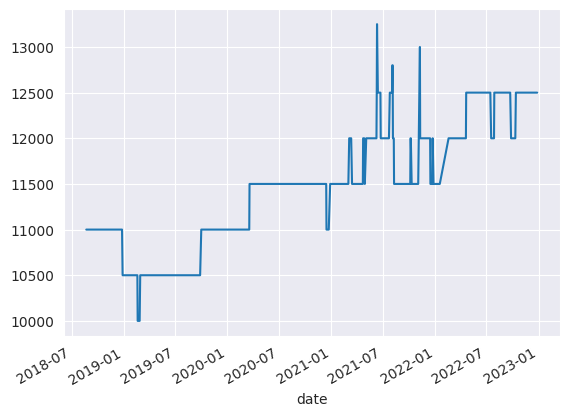

In [ ]:
df.price.plot()

In [ ]:
df

,price,area,productivity,quantity,RON 95-III
date,,,,,
2018-08-22,11000,235.0,73.5,1727.4,21.17
2018-08-23,11000,235.0,73.5,1727.4,21.17
2018-08-24,11000,235.0,73.5,1727.4,21.17
2018-08-27,11000,235.0,73.5,1727.4,21.17
2018-08-28,11000,235.0,73.5,1727.4,21.17
...,...,...,...,...,...
2022-12-19,12500,229.8,73.4,1685.9,21.20
2022-12-20,12500,229.8,73.4,1685.9,21.20
2022-12-23,12500,229.8,73.4,1685.9,20.70


## Tìm correlation tối ưu

In [ ]:
corr = df.corr(method = 'pearson')
corr

,price,area,productivity,quantity,RON 95-III
price,1.000000,-0.684531,0.510889,0.337576,0.372614
area,-0.684531,1.000000,-0.266361,0.000118,0.103019
productivity,0.510889,-0.266361,1.000000,0.963795,0.269626
quantity,0.337576,0.000118,0.963795,1.000000,0.301301
RON 95-III,0.372614,0.103019,0.269626,0.301301,1.000000


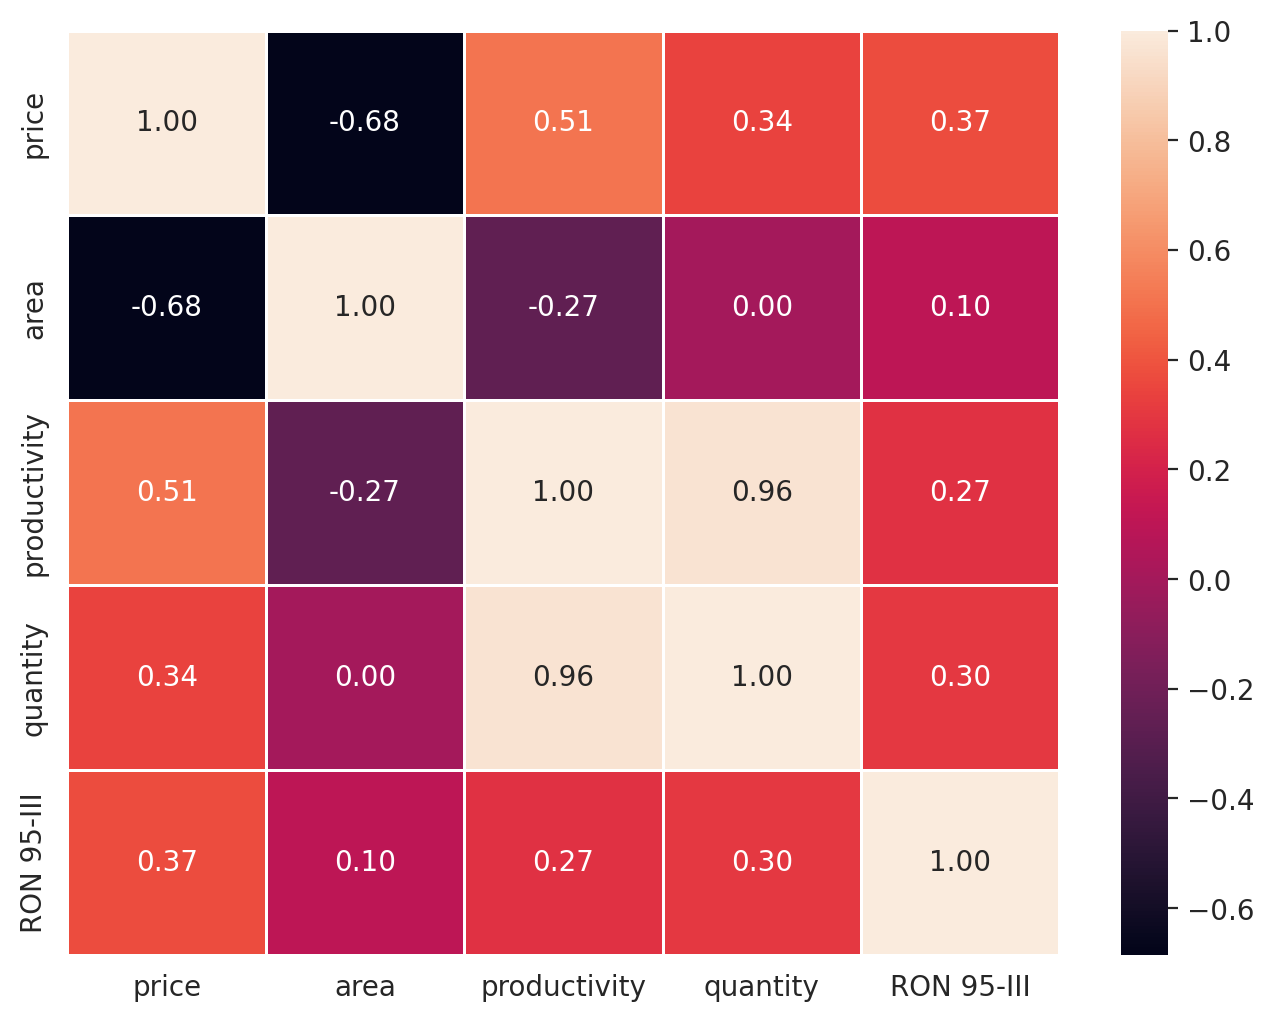

In [ ]:
plt.figure(figsize=(8,6), dpi =200)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

## Shift các cột để có corr tối ưu

In [ ]:
df.head()

,price,area,productivity,quantity,RON 95-III
date,,,,,
2018-08-22,11000,235.0,73.5,1727.4,21.17
2018-08-23,11000,235.0,73.5,1727.4,21.17
2018-08-24,11000,235.0,73.5,1727.4,21.17
2018-08-27,11000,235.0,73.5,1727.4,21.17
2018-08-28,11000,235.0,73.5,1727.4,21.17


### Phương pháp Moving average smoothing

<Axes: xlabel='date'>

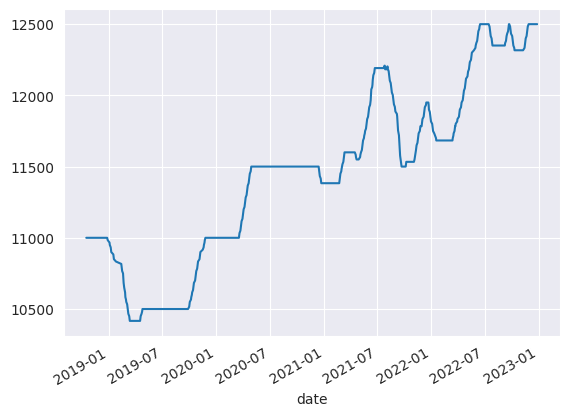

In [ ]:
df_smoothing = df.rolling(30).mean()
df_smoothing.price.plot()

In [ ]:
df_smoothing.price = df_smoothing.price.dropna()

<Axes: xlabel='date'>

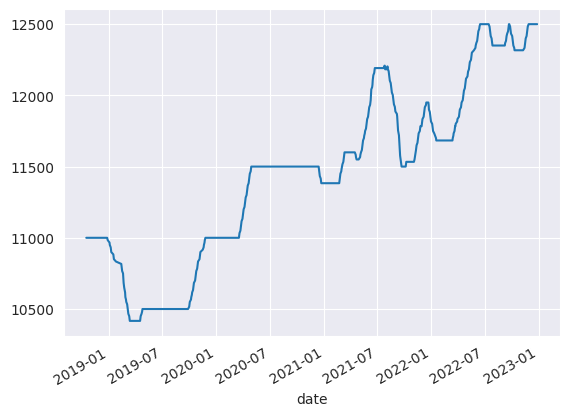

In [ ]:
df_smoothing.price.plot()

In [ ]:
df = df_smoothing

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
adf_test(df.price)

Fail to reject the null hypothesis
Data is non-stationary


In [ ]:
corr = df.corr(method = 'pearson')
corr

,price,area,productivity,quantity,RON 95-III
price,1.000000,-0.734949,0.553678,0.379166,0.389488
area,-0.734949,1.000000,-0.303754,-0.049042,0.105239
productivity,0.553678,-0.303754,1.000000,0.966458,0.283060
quantity,0.379166,-0.049042,0.966458,1.000000,0.317974
RON 95-III,0.389488,0.105239,0.283060,0.317974,1.000000


In [ ]:
train_size = int(len(df) * 0.70)
train, test = df[0:train_size], df[train_size:]

In [ ]:
df_differenced = train.diff().dropna()

In [ ]:
adf_test(df_differenced.price)

Reject the null hypothesis
Data is stationary


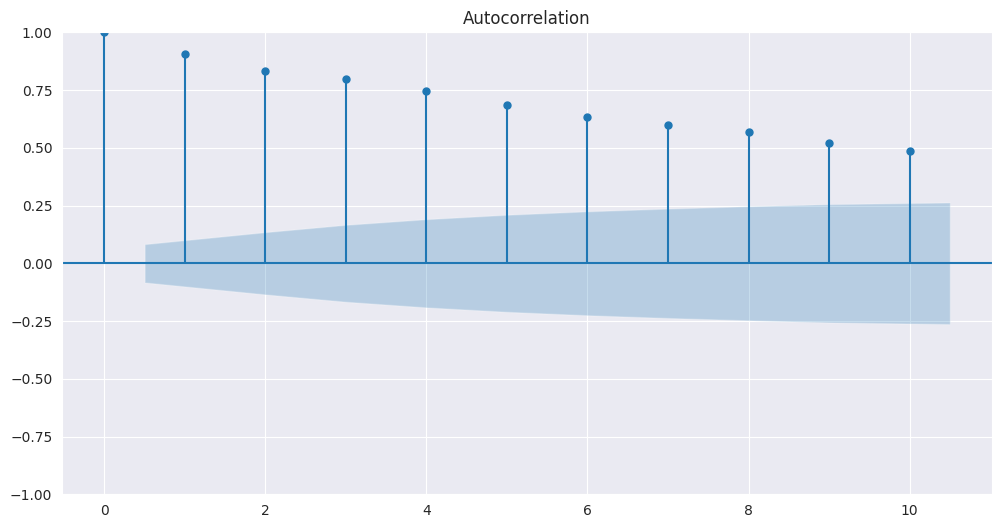

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.plot_acf(df_differenced.price, lags=10)
    plt.show()

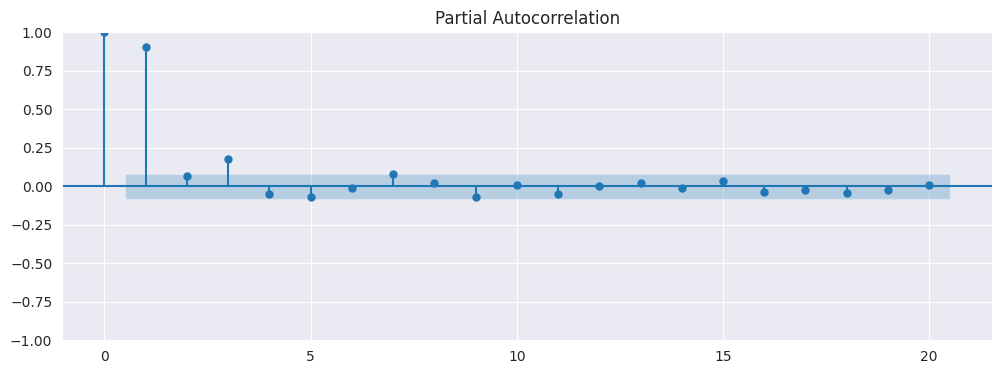

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df_differenced.price,lags=20)
    plt.show()

In [ ]:
train = df_differenced

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 558 entries, 2018-10-17 to 2021-08-25
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         558 non-null    float64
 1   area          558 non-null    float64
 2   productivity  558 non-null    float64
 3   quantity      558 non-null    float64
 4   RON 95-III    558 non-null    float64
dtypes: float64(5)
memory usage: 26.2 KB


<Axes: xlabel='date'>

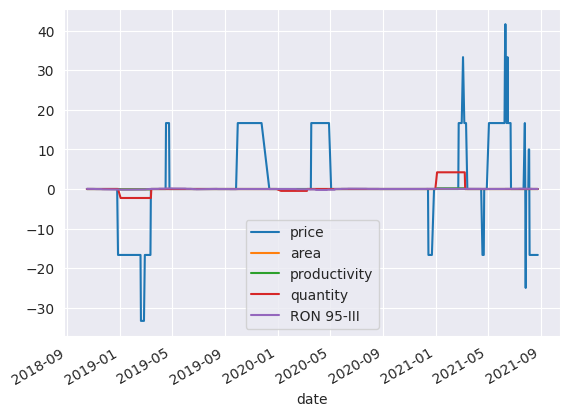

In [ ]:
train.plot()

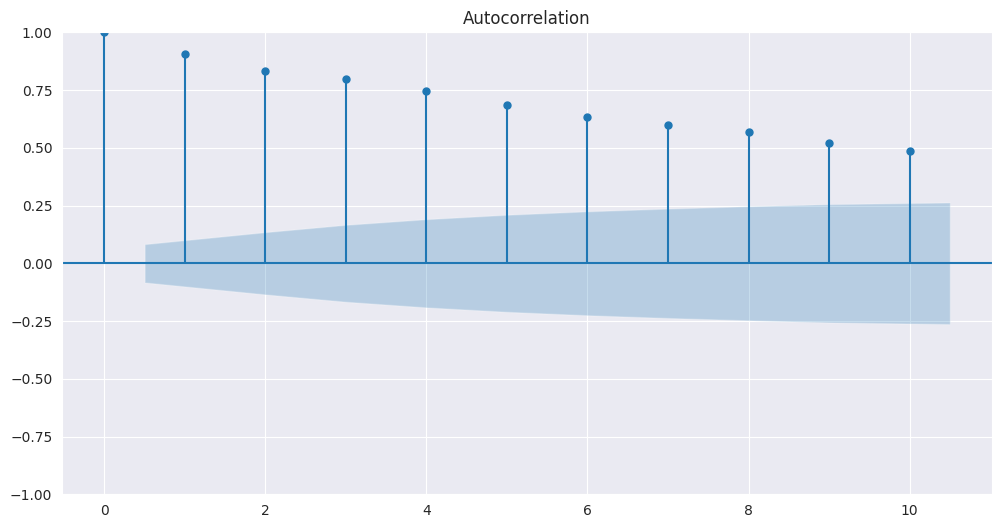

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.plot_acf(df_differenced.price, lags=10)
    plt.show()

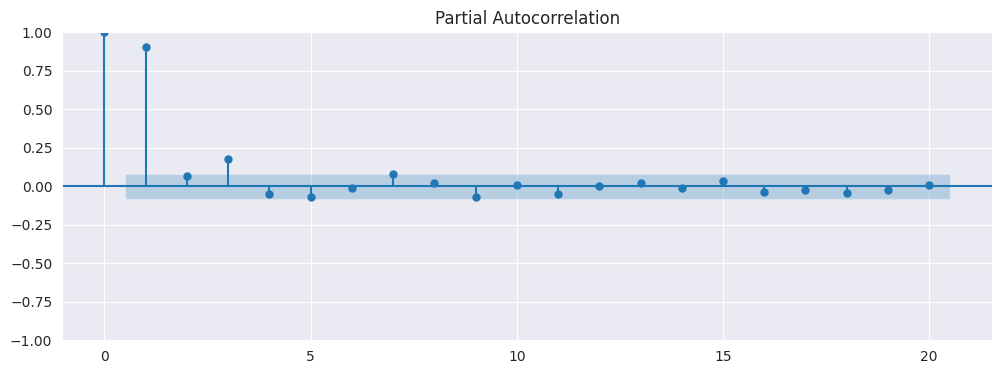

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df_differenced.price,lags=20)
    plt.show()

<Axes: xlabel='date'>

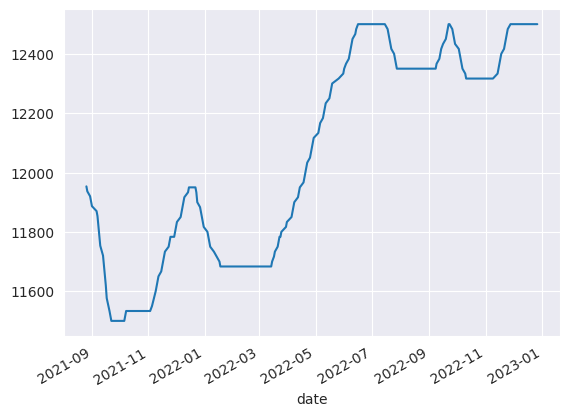

In [ ]:
test.price.plot()

<Axes: xlabel='date'>

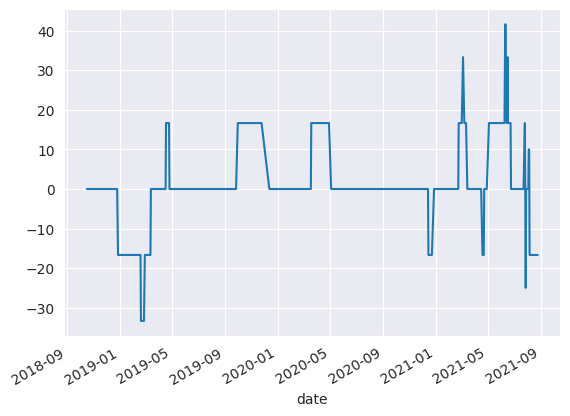

In [ ]:
train.price.plot()

In [ ]:
history = [x for x in train.price]

In [ ]:
!pip install pmdarima

In [ ]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


In [ ]:
df.sort_index(inplace=True)

In [ ]:
df['price'][-365:].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 365 entries, 2021-03-08 to 2022-12-27
Series name: price
Non-Null Count  Dtype  
--------------  -----  
365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [ ]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(train[['price']], exogenous=df[['RON 95-III']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=120,
                           start_P=0, seasonal=False,
                           d=None, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3156.166, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4150.590, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3159.033, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3667.626, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3161.911, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3145.163, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3476.761, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3145.082, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3137.645, Time=0.43 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3141.911, Time=0.18 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3139.130, Time=0.38 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3144.107, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3139.363, Time=0.63 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 3.595 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  558
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1562.823
Date:                Tue, 11 Jun 2024   AIC                           3137.645
Time:                        13:54:22   BIC                           3163.591
Sample:                             0   HQIC                          3147.778
                                - 558                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9337      0.113      8.290      0.000       0.713       1.154
ar.L2         -0.6654      0.158     -4.210      0.000      -0.975      -0.356
ar.L3          0.6310      0.076      8.315      0.000       0.482       0.780
ma.L1         -0.1073      0.120     -0.898      0.369      -0.342       0.127
ma.L2          0.5325      0.099      5.365      0.000       0.338       0.727
sigma2        15.8009      0.389     40.658      0.000      15.039      16.563
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              5074.30
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Forecast
n_periods = len(test)
fitted, confint = sxmodel.predict(n_periods=n_periods,
                                  exogenous=['RON 95-III'],
                                  return_conf_int=True)


In [ ]:
train.index[-1]

Timestamp('2021-08-25 00:00:00')

In [ ]:
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='D')

In [ ]:
index_of_fc

DatetimeIndex(['2021-08-25', '2021-08-26', '2021-08-27', '2021-08-28',
               '2021-08-29', '2021-08-30', '2021-08-31', '2021-09-01',
               '2021-09-02', '2021-09-03',
               ...
               '2022-04-24', '2022-04-25', '2022-04-26', '2022-04-27',
               '2022-04-28', '2022-04-29', '2022-04-30', '2022-05-01',
               '2022-05-02', '2022-05-03'],
              dtype='datetime64[ns]', length=252, freq='D')

In [ ]:
# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

In [ ]:
fitted

558   -15.386401
559   -14.368466
560   -13.693875
561   -12.933522
562   -12.030158
         ...    
805    -0.000004
806    -0.000003
807    -0.000003
808    -0.000003
809    -0.000003
Length: 252, dtype: float64

In [ ]:
initial_values = train.iloc[0]

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [ ]:
train

,price,area,productivity,quantity,RON 95-III
date,,,,,
2018-10-17,0.000000,0.0,0.0,0.0,0.039000
2018-10-18,0.000000,0.0,0.0,0.0,0.039000
2018-10-19,0.000000,0.0,0.0,0.0,0.039000
2018-10-22,0.000000,0.0,0.0,0.0,0.034333
2018-10-25,0.000000,0.0,0.0,0.0,0.034333
...,...,...,...,...,...
2021-08-19,-16.666667,0.0,0.0,0.0,0.025667
2021-08-20,-16.666667,0.0,0.0,0.0,0.025667
2021-08-23,-16.666667,0.0,0.0,0.0,0.025667


In [ ]:
df_forecast = pd.DataFrame()
df_forecast['price'] = fitted
df_forecast.set_index(test.index)

,price
date,
2021-08-26,-15.386401
2021-08-27,-14.368466
2021-08-30,-13.693875
2021-08-31,-12.933522
2021-09-01,-12.030158
...,...
2022-12-19,-0.000004
2022-12-20,-0.000003
2022-12-23,-0.000003


In [ ]:
train["price"].iloc[0]

0.0

In [ ]:
df_revert = df_forecast["price"].cumsum() + train["price"].iloc[0]

<Axes: >

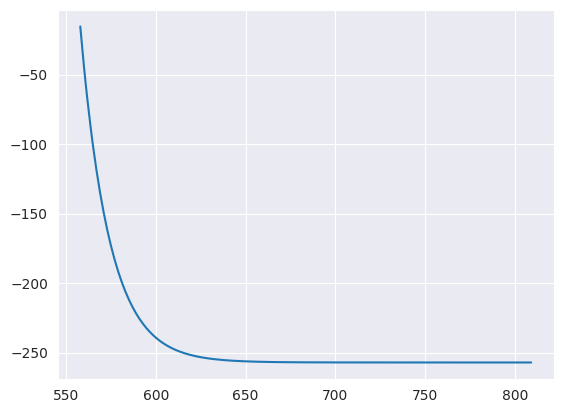

In [ ]:
df_revert.plot()

In [ ]:
original_df = invert_diff(df_forecast['price'], initial_values)

In [ ]:
original_df.head()

,price,area,productivity,quantity,RON 95-III,0
0,0.0,0.0,0.0,0.0,0.039,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_obs = len(train)

In [ ]:
df_forecast['price1d'] = (train['price'].iloc[-1]-train['price'].iloc[-2]) + df_forecast['price'].cumsum()
df_forecast['price_forecast'] = train['price'].iloc[-1] + df_forecast['price1d'].cumsum()

<Axes: >

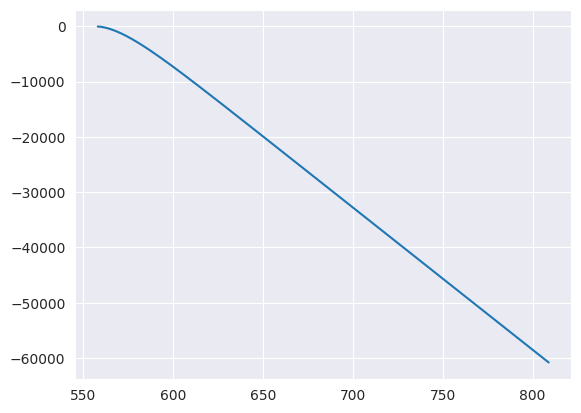

In [ ]:
df_forecast.price_forecast.plot()

In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(train[['price']], df_forecast, second_diff=True)
df_results.loc[:, ['price_forecast']]

,price_forecast
558,-32.053067
559,-61.807934
560,-105.256675
561,-161.638938
562,-230.051360
...,...
805,-59766.063136
806,-60023.228206
807,-60280.393279
808,-60537.558356


<Axes: >

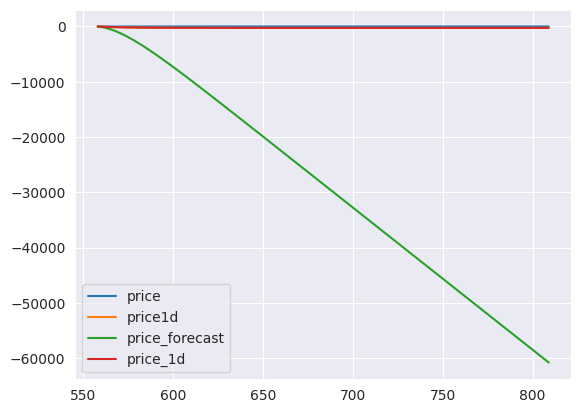

In [ ]:
df_results.plot()

In [ ]:
accuracy_prod = forecast_accuracy(fitted, test['price'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

mape :  1.0001
rmse :  12069.4322
